In [1]:
%run init_notebookspace.py
from settings import LATEX_OUT

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc as pm

from src.bayesian import grid_serach_var

az.style.use("arviz-darkgrid")
from config import seed
rng = np.random.default_rng(seed=seed)

print(pm.__version__)

5.0.1


In [3]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
}


from config import plt_config
plt.rcParams.update(plt_config)

## BVAR

In [4]:
from src.process_data import load_data
from config import fred_dict
df_in = load_data('prepro_data.csv', DATA_DIR, fred_dict)
df_in.drop('is_test', axis=1, inplace=True)
# using real potential GDP instead of GDP
print(tuple(df_in.columns))

forecast_len = 3

data = df_in[:-forecast_len].copy()
test_data = df_in[-forecast_len:].copy()
data.shape, test_data.shape

Error occured 's', file_dict may be incomplete
Error occured 'is_test', file_dict may be incomplete
('y', 'y_p', 'pi_s', 'pi', 'r', 'I', 'c_s', 'c', 'Ix', 'Zx', 'n', 'w', 's')


((148, 13), (3, 13))

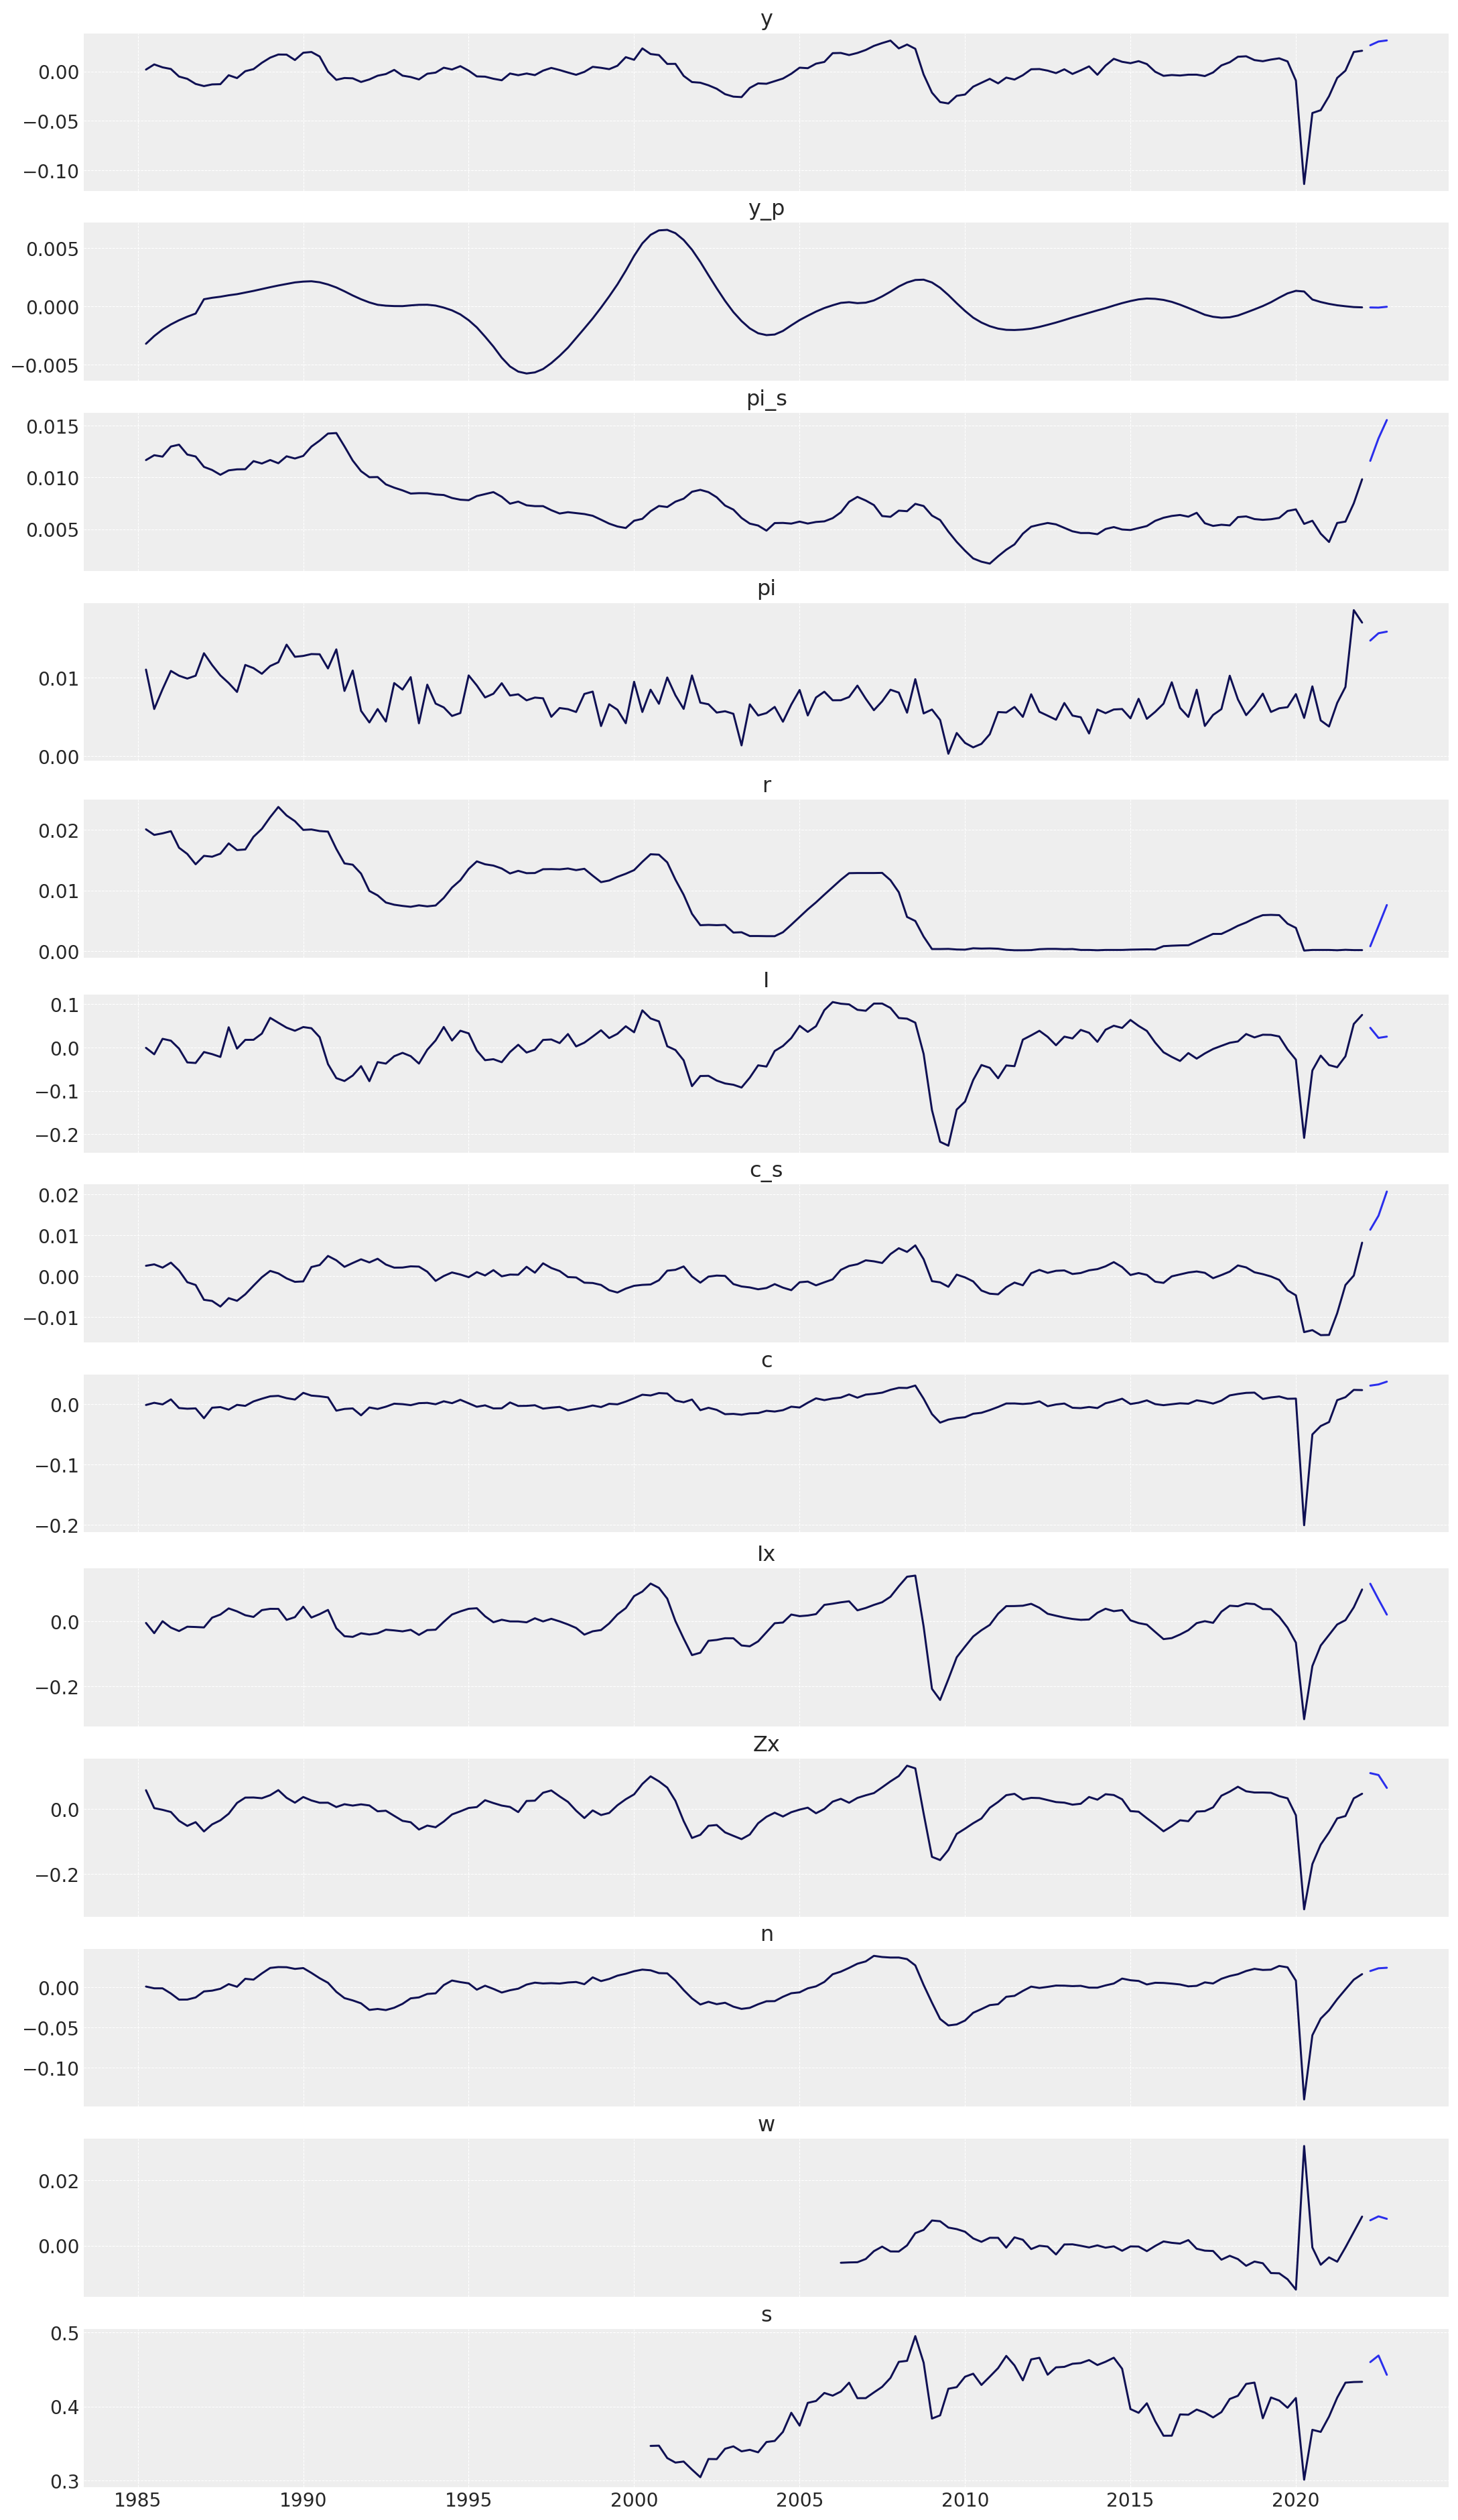

In [5]:
_, ax = plt.subplots(data.shape[1], 1, figsize=(15, 2 * data.shape[1]), sharex=True)

for i in range(0, data.shape[1]):
    ax[i].plot(data.iloc[:, i], color=dark["C0"], label="train")
    ax[i].plot(test_data.iloc[:, i], color="C0", label="test")
    ax[i].set_title(data.columns[i])
    
    # ax[i].axvline(data.index[-forecast_len], ls='--', color='k')


In [18]:
df = data[['y', 'c', 'n',]].iloc[-70:].copy()

In [19]:
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": tuple(df.columns),
    "cross_vars": tuple(df.columns),
    "time": range(len(df) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_list = []
    for ind in range(0, len(coords['cross_vars'])):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[i, ind] * df.values[lags-(i+1): -(i+1)], axis=-1) for i in range(lags)
            ]
            , axis=0
        )        
        ar_list.append(ar)
        
    mean = intercept + pm.math.stack(ar_list, axis=-1)

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=df[lags:], dims=("time", "vars"))

In [20]:
with BVAR_model:
    trace = pm.sample(chains=4, draws=2_000, random_seed=rng, idata_kwargs={'log_likelihood':True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 83 seconds.


In [10]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [11]:
# az.plot_trace(trace);

Text(0.5, 1.0, 'Posterior 94% HDI')

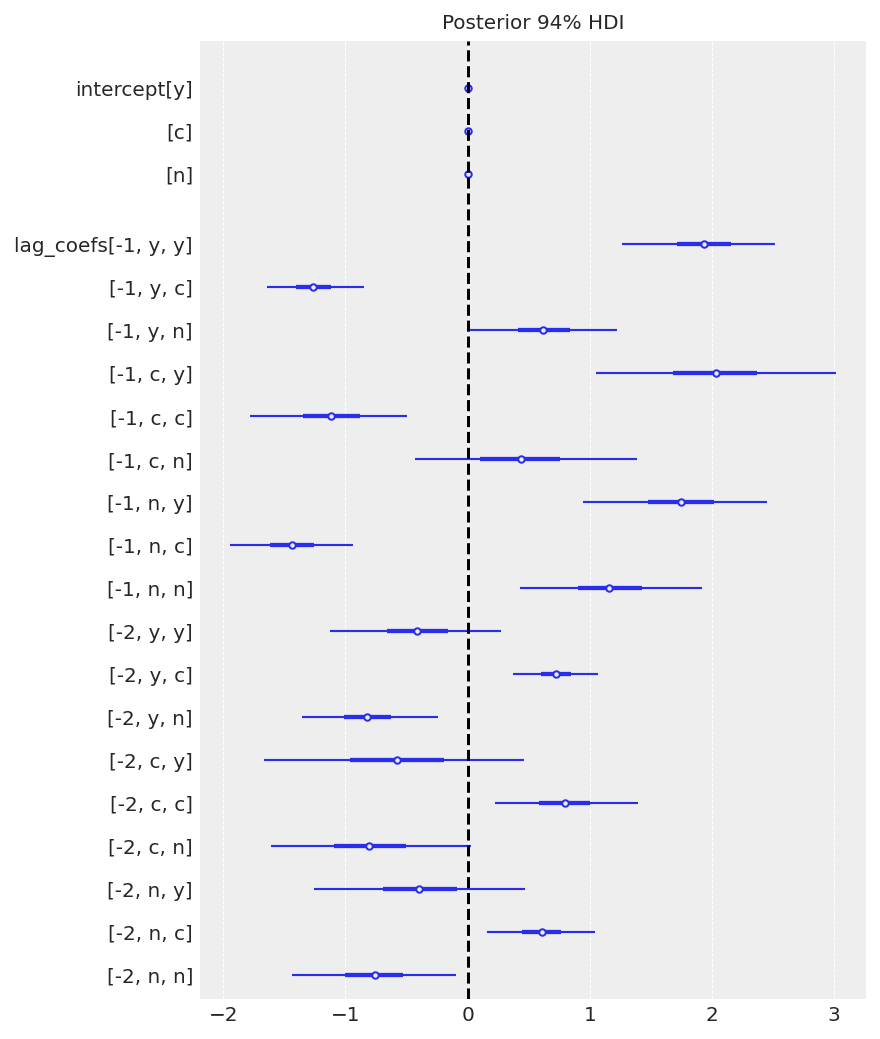

In [21]:
axes = az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI", size=10)
# axes[0].figure.savefig(os.path.join(LATEX_OUT, 'BVAR_coeff.png'))

In [22]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=3):
    len_data = len(df)
    new_draws = np.zeros((df.shape[0]+forecast, df.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = df[:]
    for i in range(forecast):
        ar_list = []
        for ind in range(0, len(coords['cross_vars'])):
            ar = np.sum(lag_coefs[:, ind] * new_draws[len_data+i-lags: len_data+i])
            ar_list.append(ar)
        mean = intercept + np.stack(ar_list)
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

from src.bayesian import bvar_forecast

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    # bvar_forecast(df, coords, lags, intercept, lag_coefs, noise, forecast=10),
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [23]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(1000, size=200)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

((200, 3), (200, 2, 3, 3), (200, 3))

In [24]:
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=forecast_len)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

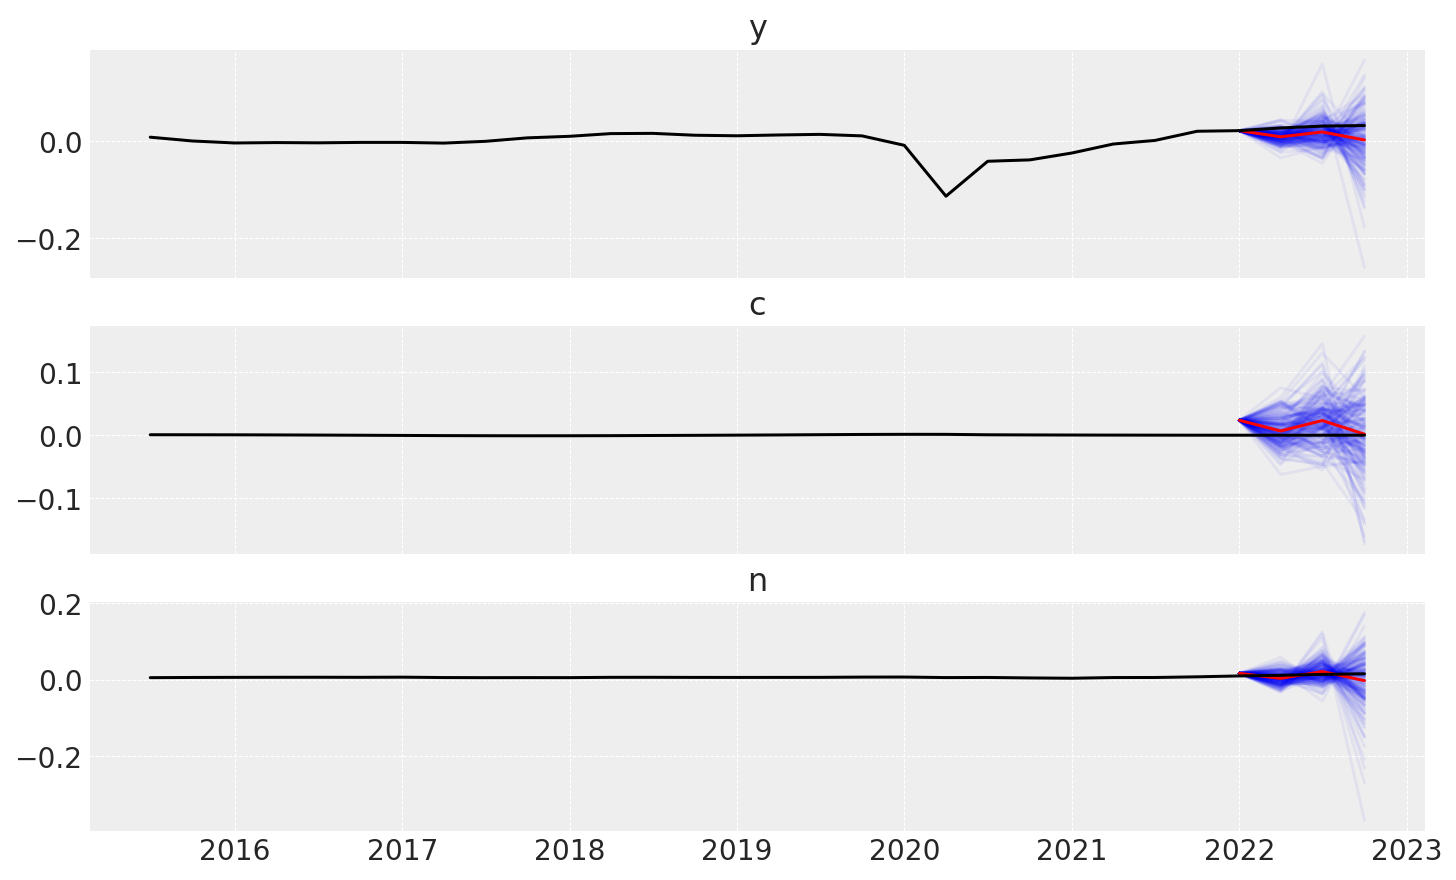

In [52]:
plot_time = 30
# ind = 

fig, ax = plt.subplots(df.shape[1], 1, figsize=(10, 2 * df.shape[1]), sharex=True)
for i in range(0, df.shape[1]):
    ax[i].plot(df_in.index[-plot_time:], ppc_draws[-plot_time:,:,i], color="blue", alpha=.05)
    ax[i].plot(df_in.index[-plot_time:], ppc_draws[-plot_time:,:,i].mean(axis=1), color='red')
    ax[i].plot(df_in.iloc[-plot_time:, i], color="k", label="observed")
    ax[i].set_title(df.columns[i])
    ax[0].plot([], color="C0", label="forecast")
    

# fig.savefig(os.path.join(LATEX_OUT, 'bvar_forecast.png'))

In [172]:
forecast_dict = {
    'forecast': pd.DataFrame(ppc_draws[-3:].mean(axis=1), columns=df.columns),
    # 'true': test[total_vars]
}

import pickle 
with open(os.path.join(DATA_DIR, f'bvar_forecast.pkl'), 'wb') as f:
    pickle.dump(forecast_dict, f)

In [43]:
# save output

In [44]:
from settings import POST_EST_DIR

from datetime import datetime

a = ''.join(str(datetime.now().date()).split('-'))
b = ''.join((str(datetime.now().time()).split(':'))[:-1])
timestamp = '_'.join([a, b])
file_path_acc = os.path.join(POST_EST_DIR, f'bvar_accepted_{timestamp}.nc')
trace.to_netcdf(file_path_acc)

'C:\\Users\\LukasGrahl\\Documents\\GIT\\memoire1\\data\\posterior_est_out\\bvar_accepted_20230523_1409.nc'